# Poison Populations

In [1]:
# Overhead
import numpy as np
from matplotlib import pyplot as plt

seconds_per_day = 60*60*24

### Behavior of poison populations during three periods
We need to show the behavior of three neutron poisons (iodine, xenon, and samarium) over three periods in the operating lifetime of a reactor. First, we will observe what happens to the populations if the reactor is immediately turned on at time $t_0$, going from 0 to 100% power immediately. We will then let the poison populations equilibrate before reducing the power by 50% at time $t_1$. Finally, after the poison populations equilibrate again, we will shut down the reactor completely.

In [2]:
t0,t1,t2 = 0,3e5,6e5

step = 1
# First interval
t0t1 = np.arange(t0,t1,step)
phi_0 = 5e14

# Second interval
t1t2 = np.arange(t1,t2,step)
phi_1 = phi_0/2

# Third interval
phi_2 = 0
t2inf = np.arange(t2,2*t2-t1,step)

In all cases, we have assumed $\Sigma_f = 1$, as it does not affect the shape of any product's behavior over time (just the magnitude of the population).

In [3]:
def plot_concentrations(isotope,intervals,concentrations,norm_factor=1):
    fig,ax = plt.subplots(figsize=(12,8))
    for interval,concentration in zip(intervals,concentrations):
        ax.plot(interval/seconds_per_day,concentration/norm_factor)
    ax.set_xlabel('Time [days]',fontsize=18)
    ax.set_title('{}, as a fraction of the full-power equilibrium concentration'.format(isotope.title()),fontsize=18)
    ax.tick_params(labelsize=16)
    plt.tight_layout()
    plt.show()

## Iodine

$T_{1/2,I} = 6.7\text{ hr}$  (iodine half-life)  
$\gamma_I = 0.0639$ (iodine yield per U-235 fission, in atoms)  

In [4]:
T_half_I = 6.7*3600               # [s]
lambda_I = np.log(2)/T_half_I     # [s^{-1}]
gamma_I = 0.0639

The equation describing the rate of change of the iodine population given some flux, $\phi$, is:

$$ \frac{dI}{dt} = \gamma_I \bar{\Sigma}_f \phi - \lambda_I I(t) .$$

We solve this to find the equation for iodine population:

$$ I(t) = \frac{\gamma_I \Sigma_f \phi}{\lambda_I} + \left(I_0 - \frac{\gamma_I \Sigma_f \phi}{\lambda_I}\right) e^{-\lambda_I t} $$

In [5]:
def iodine(t,phi,I_0):
    gxp_div_lamI = (gamma_I*phi)/lambda_I
    I = gxp_div_lamI + (I_0 - gxp_div_lamI)*np.exp(-lambda_I*t)
    return I

We use this relationship to calculate and then plot the iodine concentrations (normalized to the full-power equilibrium concentration of iodine).

In [6]:
# First interval
I0I1 = iodine(t0t1,phi_0,0)
I1_equil = I0I1[-1]

# Second interval
I1I2 = iodine(t1t2-t1t2[0],phi_1,I1_equil)
I2_equil = I1I2[-1]

# Third interval
I2inf = iodine(t2inf-t2inf[0],phi_2,I2_equil)

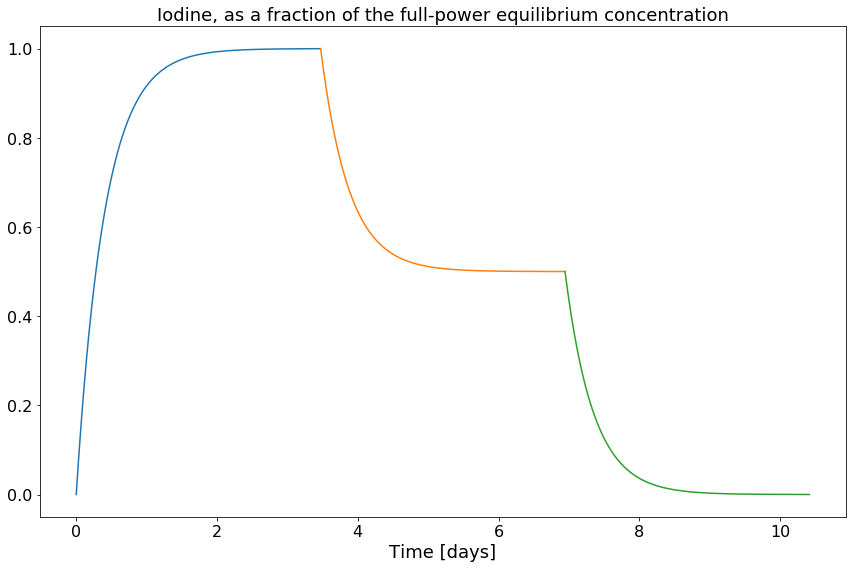

In [7]:
plot_concentrations('iodine',[t0t1,t1t2,t2inf],[I0I1,I1I2,I2inf],I1_equil)

## Xenon

$T_{1/2,X} = 9.2\text{ hr}$  (xenon half-life)  
$\gamma_X = 0.00237$ (xenon yield per U-235 fission, in atoms)  
$\sigma_{a,X} = 2.65\times10^6 \text{ b}$ (xenon thermal absorption cross section)  

In [8]:
T_half_X = 9.2*3600               # [s]
lambda_X = np.log(2)/T_half_X     # [s^{-1}]
gamma_X = 0.00237
sigma_aX = 2.65e6*1e-24           # cm^2

The equation describing the rate of change of the xenon population given some flux, $\phi$, is:

$$ \frac{dX}{dt} = \gamma_X \bar{\Sigma}_f \phi + \lambda_I I(t) - \lambda_X X(t) - \sigma_{a,X} \phi X(t) .$$

We solve this to find the equation for xenon population:

$$ X(t) = \frac{\Sigma_f \phi \left(\gamma_I + \gamma_X\right)}{\lambda_X + \sigma_{a,X} \phi} \left(1 - e^{-\left(\lambda_X + \sigma_{a,X} \phi\right)t}\right) + \frac{I_0 \lambda_I - \gamma_I \Sigma_f \phi}{\lambda_X + \sigma_{a,X} \phi - \lambda_I} \left(e^{-\lambda_I t} - e^{-\left(\lambda_X + \sigma_{a,X} \phi\right)t}\right) + X_0 e^{-\left(\lambda_X + \sigma_{a,X} \phi\right)t}$$

In [9]:
def xenon(t,phi,X_0,I_0):
    Xrate = lambda_X + sigma_aX*phi
    Xrate_min_Irate = Xrate - lambda_I
    exp_X = np.exp(-Xrate*t)
    exp_I = np.exp(-lambda_I*t)
    X = (phi*(gamma_I+gamma_X)/Xrate)*(1 - exp_X) + ((I_0*lambda_I-gamma_I*phi)/Xrate_min_Irate)*(exp_I - exp_X) + X_0*exp_X
    return X

We use this relationship to calculate and then plot the xenon concentrations (normalized to the full-power equilibrium concentration of xenon).

In [10]:
# First interval
X0X1 = xenon(t0t1,phi_0,0,0)
X1_equil = X0X1[-1]

# Second interval
X1X2 = xenon(t1t2-t1t2[0],phi_1,X1_equil,I1_equil)
X2_equil = X1X2[-1]

# Third interval
X2inf = xenon(t2inf-t2inf[0],phi_2,X2_equil,I2_equil)

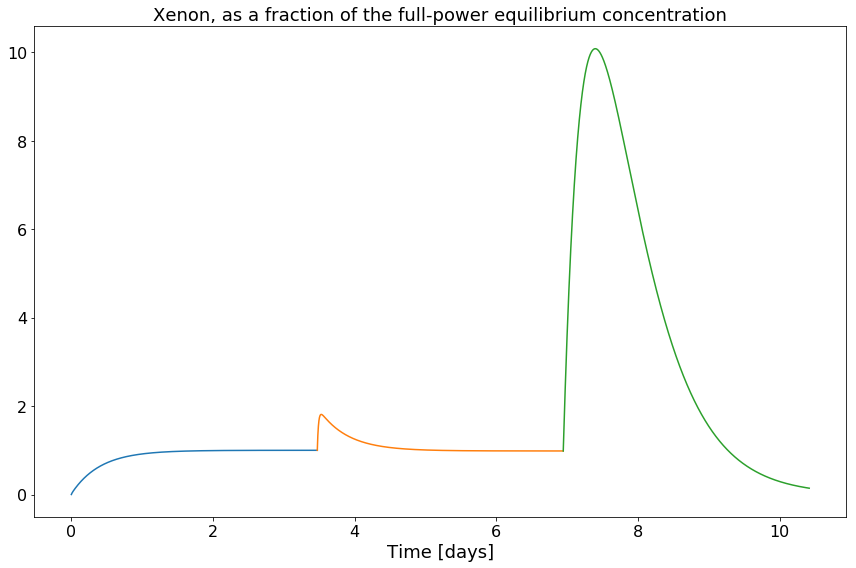

In [11]:
plot_concentrations('xenon',[t0t1,t1t2,t2inf],[X0X1,X1X2,X2inf],X1_equil)

Note that it appears in this plot that the xenon returns to the same equilibrium concentration for any flux. This is not exactly true. Do understand what is happening, we look at the first term–the only term that remains if $t\rightarrow\infty$. In the denominator, the product of the xenon absorption cross section and flux dominate the xenon decay constant, and so the flux in the numerator and denominator effectively cancel. If we make test a decay constant for xenon that is slightly larger, say $\lambda_X = 0.0001\text{ s}$, we see the equilibrium level change drastically.

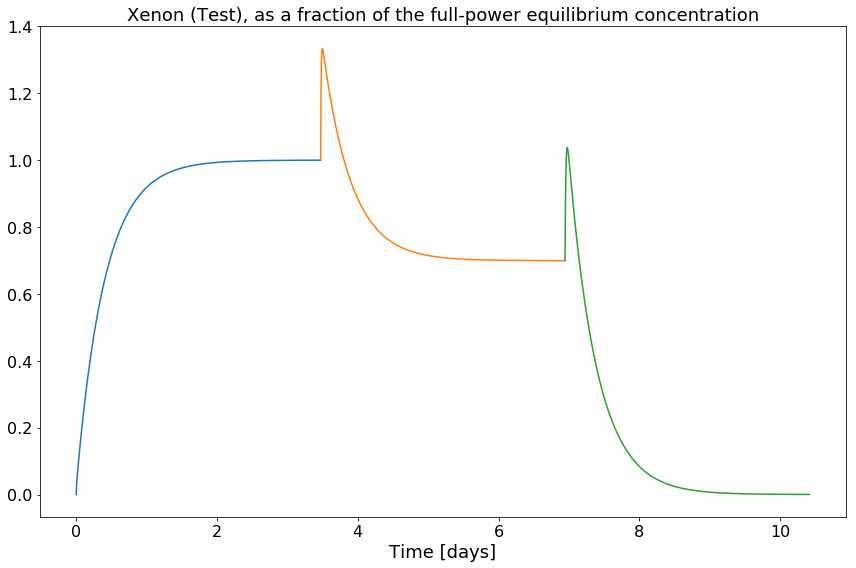

In [12]:
lambda_X = 0.001

# First interval
X0X1_test = xenon(t0t1,phi_0,0,0)
X1_equil_test = X0X1_test[-1]

# Second interval
X1X2_test = xenon(t1t2-t1t2[0],phi_1,X1_equil_test,I1_equil)
X2_equil_test = X1X2_test[-1]

# Third interval
X2inf_test = xenon(t2inf-t2inf[0],phi_2,X2_equil_test,I2_equil)

plot_concentrations('xenon (test)',[t0t1,t1t2,t2inf],[X0X1_test,X1X2_test,X2inf_test],X1_equil_test)

For promethium and samarium, we will redefine the periods to more effectively demonstrate the behavior.

In [13]:
t0,t1,t2 = 0,2e6,4e6

# First interval
t0t1 = np.arange(t0,t1,step)

# Second interval
t1t2 = np.arange(t1,t2,step)

# Third interval
t2inf = np.arange(t2,2*t2-t1,step)

## Promethium

$T_{1/2,P} = 53\text{ hr}$  (promethium half-life)  
$\gamma_P = 0.01071$ (promethium yield per U-235 fission, in atoms)  

In [14]:
T_half_P = 53*3600                # [s]
lambda_P = np.log(2)/T_half_P     # [s^{-1}]
gamma_P = 0.01071

The equation describing the rate of change of the promethium population given some flux, $\phi$, is:

$$ \frac{dP}{dt} = \gamma_P \bar{\Sigma}_f \phi - \lambda_P P(t) .$$

We solve this to find the equation for promethium population:

$$ P(t) = \frac{\gamma_P \Sigma_f \phi}{\lambda_P} + \left(P_0 - \frac{\gamma_P \Sigma_f \phi}{\lambda_P}\right) e^{-\lambda_P t} $$

In [15]:
def promethium(t,phi,P_0):
    gxp_div_lamP = (gamma_P*phi)/lambda_P
    P = gxp_div_lamP + (P_0 - gxp_div_lamP)*np.exp(-lambda_P*t)
    return P

We use this relationship to calculate and then plot the promethium concentrations (normalized to the full-power equilibrium concentration of promethium).

In [16]:
# First interval
P0P1 = promethium(t0t1,phi_0,0)
P1_equil = P0P1[-1]

# Second interval
P1P2 = promethium(t1t2-t1t2[0],phi_1,P1_equil)
P2_equil = P1P2[-1]

# Third interval
P2inf = promethium(t2inf-t2inf[0],phi_2,P2_equil)

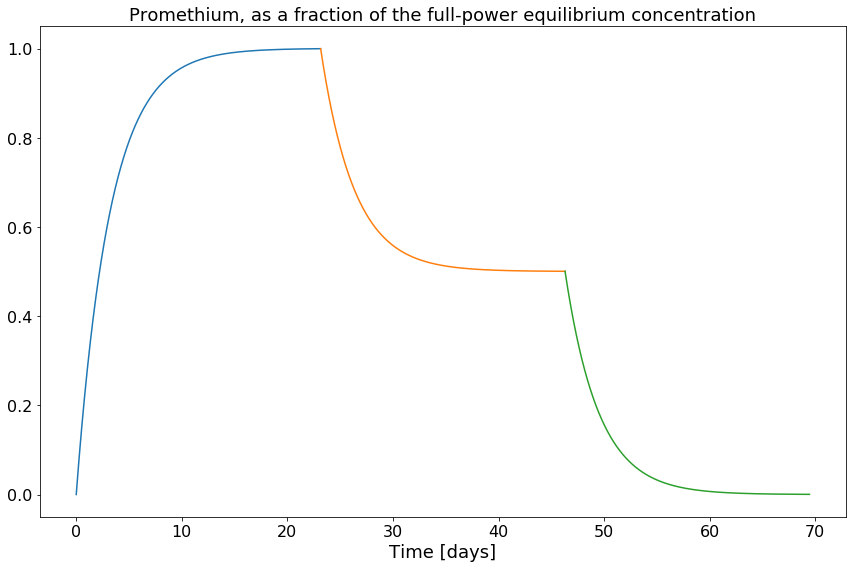

In [17]:
plot_concentrations('promethium',[t0t1,t1t2,t2inf],[P0P1,P1P2,P2inf],P1_equil)

## Samarium

$\sigma_{a,S} = 41,000\text{ b}$ (samarium thermal absorption cross section)  

In [18]:
sigma_aS = 41000*1e-24            # cm^2

The equation describing the rate of change of the samarium population given some flux, $\phi$, is:

$$ \frac{dS}{dt} = \lambda_P P(t) - \sigma_{a,S} \phi S(t) .$$

Using our previously found expression for $P(t)$, we solve this to find the equation for samarium population:

$$ S(t) = \frac{\gamma_P \bar{\Sigma}_f}{\sigma_{a,S}} \left(1 - e^{-\sigma_{a,S} \phi t}\right) + \frac{P_0 \lambda_P - \gamma_P \Sigma_f \phi}{\sigma_{a,S} \phi - \lambda_P} \left(e^{-\lambda_P t} - e^{-\sigma_{a,S} \phi t}\right) + S_0 e^{-\sigma_{a,S} \phi t} $$

In [19]:
def samarium(t,phi,S_0,P_0):
    Srate_min_Prate = sigma_aS*phi - lambda_P
    exp_S = np.exp(-sigma_aS*phi*t)
    exp_P = np.exp(-lambda_P*t)
    S = (gamma_P/sigma_aS)*(1 - exp_S) + ((P_0*lambda_P-gamma_P*phi)/Srate_min_Prate)*(exp_P - exp_S) + S_0*exp_S
    return S

We use this relationship to calculate and then plot the samarium concentrations (normalized to the full-power equilibrium concentration of samarium).

In [20]:
# First interval
S0S1 = samarium(t0t1,phi_0,0,0)
S1_equil = S0S1[-1]

# Second interval
S1S2 = samarium(t1t2-t1t2[0],phi_1,S1_equil,P1_equil)
S2_equil = S1S2[-1]

# Third interval
S2inf = samarium(t2inf-t2inf[0],phi_2,S2_equil,P2_equil)

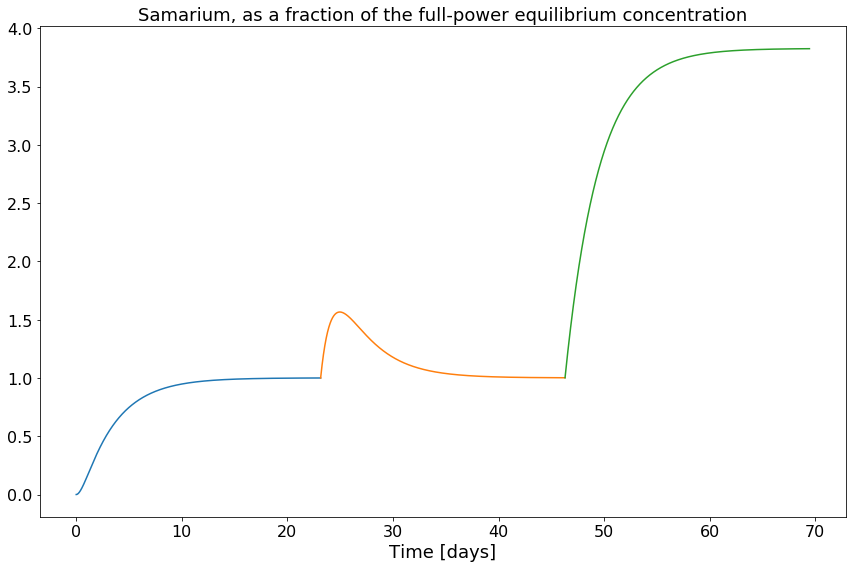

In [21]:
plot_concentrations('samarium',[t0t1,t1t2,t2inf],[S0S1,S1S2,S2inf],S1_equil)